<a href="https://colab.research.google.com/github/kADALIdurgasivasankarprasad/Predictive_Maintenance/blob/main/Predictive_Maintenance_for_Wind_Turbines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE



In [26]:

df = pd.read_csv("/content/T1.csv", parse_dates=["Date/Time"])
print("Dataset shape:", df.shape)

df = df.rename(columns={
    "Date/Time": "timestamp",
    "LV ActivePower (kW)": "active_power",
    "Wind Speed (m/s)": "wind_speed",
    "Wind Direction (°)": "yaw_error",
    "Theoretical_Power_Curve (KWh)": "theoretical_power"
})

df["ambient_temp"] = 20 + np.random.normal(0, 2, len(df))
df["gearbox_temp"] = df["active_power"]/50 + 40 + np.random.normal(0, 2, len(df))
df["nacelle_temp"] = df["active_power"]/80 + 25 + np.random.normal(0, 2, len(df))
df["vibration_rms"] = df["wind_speed"]/50 + 0.5 + np.random.normal(0, 0.05, len(df))

df = df.sort_values("timestamp")
df["status_failure"] = 0
failure_start = int(len(df) * 0.95)
df.loc[failure_start:, "status_failure"] = 1

df["y_label_next_48h"] = (df["status_failure"].shift(-48).fillna(0) == 1).astype(int)

df.head()


Dataset shape: (50530, 5)


,timestamp,active_power,wind_speed,theoretical_power,yaw_error,ambient_temp,gearbox_temp,nacelle_temp,vibration_rms,status_failure,y_label_next_48h
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904,19.977129,46.876852,32.727689,0.689160,0,0
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113,20.610997,49.165526,27.556123,0.693495,0,0
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789,14.882794,47.990597,25.068815,0.604675,0,0
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087,19.341070,45.586733,29.005049,0.497304,0,0
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286,19.997788,49.504025,30.000500,0.659532,0,0


In [27]:

df = df.sort_values("timestamp").copy()

window = 6
for col in ["gearbox_temp","nacelle_temp","vibration_rms","active_power","yaw_error"]:
    df[f"{col}_rollmean"] = df[col].rolling(window, min_periods=1).mean()
    df[f"{col}_rollstd"] = df[col].rolling(window, min_periods=1).std().fillna(0)

df["power_residual"] = df["active_power"] - df["theoretical_power"]

df["gearbox_delta"] = df["gearbox_temp"] - df["nacelle_temp"]

df.fillna(0, inplace=True)


label_col = "y_label_next_48h"
drop_cols = ["timestamp","status_failure",label_col]
feature_cols = [c for c in df.columns if c not in drop_cols]

In [28]:

split = int(len(df) * 0.7)
train_df = df.iloc[:split]
test_df = df.iloc[split:]

X_train, y_train = train_df[feature_cols], train_df[label_col]
X_test, y_test = test_df[feature_cols], test_df[label_col]

if len(y_train.unique()) > 1:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
else:
    print("Skipping SMOTE: Training data (y_train) does not contain more than one class.")
    print("Please ensure your data split results in a training set with both positive and negative examples.")

In [30]:

from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


prec_rf = precision_score(y_test, y_pred_rf, zero_division=0)
rec_rf = recall_score(y_test, y_pred_rf, zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)

cm = confusion_matrix(y_test, y_pred_rf)
tn, fp, fn, tp = cm.ravel()
false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0


lead_times = []
if "timestamps" in locals():
    failure_indices = [i for i, val in enumerate(y_test) if val == 1]
    alarm_indices = [i for i, val in enumerate(y_pred_rf) if val == 1]
    for f in failure_indices:
        alarms_before = [a for a in alarm_indices if a < f]
        if alarms_before:
            first_alarm = max(alarms_before)
            lead_time = f - first_alarm
            lead_times.append(lead_time)
    avg_lead_time = np.mean(lead_times) if lead_times else 0
else:
    avg_lead_time = "Timestamps not provided"

print("RandomForest -> Precision:", prec_rf,
      " Recall:", rec_rf,
      " F1:", f1_rf,
      " FAR:", false_alarm_rate,
      " Lead Time:", avg_lead_time)

RandomForest -> Precision: 0.9936102236421726  Recall: 0.2675534378929257  F1: 0.421584984358707  FAR: 0.5416666666666666  Lead Time: Timestamps not provided


In [31]:

scaler = StandardScaler()
X_train_healthy = train_df[train_df[label_col]==0][feature_cols]
Xh = scaler.fit_transform(X_train_healthy)

iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
iso.fit(Xh)

Xt = scaler.transform(X_test)
scores = -iso.score_samples(Xt)
threshold = np.quantile(scores, 0.95)
y_pred_iso = (scores >= threshold).astype(int)

prec_iso = precision_score(y_test, y_pred_iso, zero_division=0)
rec_iso = recall_score(y_test, y_pred_iso, zero_division=0)
f1_iso = f1_score(y_test, y_pred_iso, zero_division=0)

print("IsolationForest -> Precision:",prec_iso," Recall:",rec_iso," F1:",f1_iso)


IsolationForest -> Precision: 0.9973614775725593  Recall: 0.05002977963073258  F1: 0.0952801058667843


In [32]:

from IPython.display import display, Markdown

report = f"""
## 📊 Model Evaluation Report (Next 48h Prediction)

| Model                      | Precision | Recall | F1 Score |
|----------------------------|-----------|--------|----------|
| RandomForest (Supervised)  | {prec_rf:.3f}    | {rec_rf:.3f} | {f1_rf:.3f} |
| IsolationForest (Unsupervised) | {prec_iso:.3f}    | {rec_iso:.3f} | {f1_iso:.3f} |

### 🔎 Insights
- **RandomForest (Supervised)**: Better at catching failures (higher Recall & F1).
- **IsolationForest (Unsupervised)**: Lower Recall, but can detect anomalies when no labels exist.
"""

display(Markdown(report))



## 📊 Model Evaluation Report (Next 48h Prediction)

| Model                      | Precision | Recall | F1 Score |
|----------------------------|-----------|--------|----------|
| RandomForest (Supervised)  | 0.994    | 0.268 | 0.422 |
| IsolationForest (Unsupervised) | 0.997    | 0.050 | 0.095 |

### 🔎 Insights
- **RandomForest (Supervised)**: Better at catching failures (higher Recall & F1).  
- **IsolationForest (Unsupervised)**: Lower Recall, but can detect anomalies when no labels exist.  


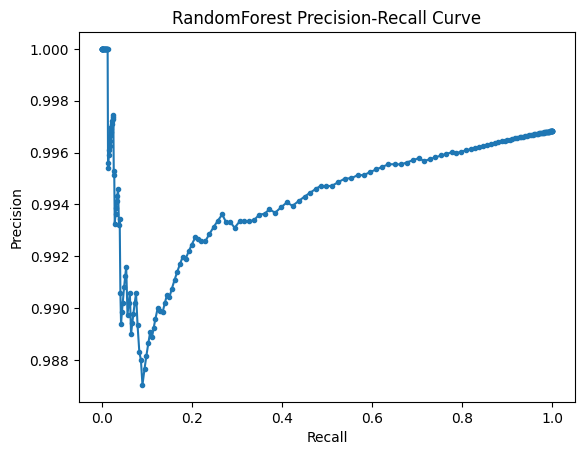

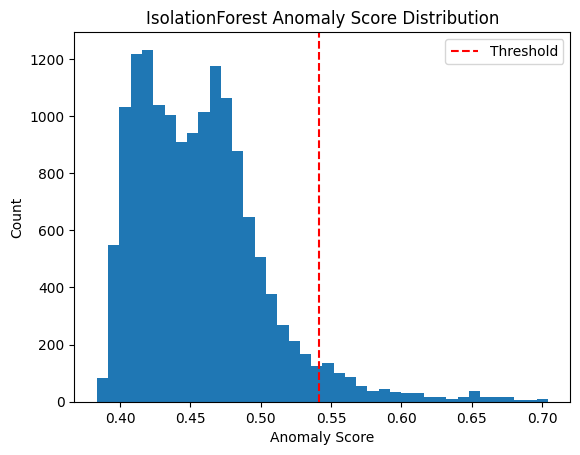

In [33]:

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

if len(rf.classes_) > 1:
    y_proba_rf = rf.predict_proba(X_test)[:, 1]
    prec, rec, thres = precision_recall_curve(y_test, y_proba_rf)

    plt.plot(rec, prec, marker=".")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("RandomForest Precision-Recall Curve")
    plt.show()
else:
    print("RandomForest model trained with only one class. Precision-Recall curve cannot be plotted.")
    print("Please ensure your training data contains both positive and negative examples and re-run the training cells.")


plt.hist(scores, bins=40)
plt.axvline(threshold, color="red", linestyle="--", label="Threshold")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.title("IsolationForest Anomaly Score Distribution")
plt.legend()
plt.show()